In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "cpu"
import jax
import mmml
import numpy as np
import matplotlib.pyplot as plt
print(jax.devices())
data = np.load("data-full.npz", allow_pickle=True)
keys = data.keys()
# quick peek at shapes/dtypes
for k in keys:
    arr = data[k]
    try:
        print(f"{k:20s} shape={arr.shape} dtype={arr.dtype}")
    except Exception:
        print(f"{k:20s} (could not read shape)")

ERROR:2026-02-13 12:29:42,382:jax._src.xla_bridge:473: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/scicore/home/meuwly/boitti0000/.conda/envs/mmml-full/lib/python3.12/site-packages/jax/_src/xla_bridge.py", line 471, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/scicore/home/meuwly/boitti0000/.local/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/scicore/home/meuwly/boitti0000/.local/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: CUDA_ERROR_NO_DEVICE


[CpuDevice(id=0)]
R                    shape=(10000, 1, 29, 3) dtype=object
Z                    shape=(10000, 29) dtype=object
D                    shape=(10000, 3) dtype=object
E                    shape=(10000,) dtype=object
F                    shape=(10000, 1, 29, 3) dtype=object
P                    shape=(10000, 1, 3, 3) dtype=object
Ef                   shape=(10000, 3) dtype=object


In [2]:
data["D"][0]

array([-0.5065, 3.6606, -4.1603], dtype=object)

In [3]:
data["P"][0]

array([[[154.721, 8.872, 15.501],
        [8.872, 146.36, 6.612],
        [15.501, 6.612, 132.559]]], dtype=object)

In [4]:
data["P"][1]

array([[[153.889, -8.378, -16.206],
        [-8.378, 145.657, 5.852],
        [-16.206, 5.852, 132.689]]], dtype=object)

In [5]:
out_dict = {}
for k in keys:
    out_dict[k] = data[k]
    if k == "F":
        out_dict[k] = -1.0 * out_dict[k]
np.savez("data-full-flipped.npz", **out_dict)

In [10]:
np.arange(1, 10000, 2)

array([   1,    3,    5, ..., 9995, 9997, 9999], shape=(5000,))

In [7]:
out_dict = {}
for k in keys:
    out_dict[k] = data[k][np.arange(0, 10000, 2)]
np.savez("data-full-set1.npz", **out_dict)

In [11]:
out_dict = {}
for k in keys:
    out_dict[k] = data[k][np.arange(1, 10000, 2)]
np.savez("data-full-set2.npz", **out_dict)

In [6]:
import numpy as np
import matplotlib.pyplot as plt

R_obj = data["R"]                       # (10000, 1, 29, 3) object
R = np.asarray(R_obj, dtype=float)      # convert object -> float
R = R[:, 0, :, :]                       # (10000, 29, 3)

print(R.shape, R.dtype)

(10000, 29, 3) float64


(array([3.248e+03, 2.578e+03, 1.972e+03, 1.181e+03, 6.150e+02, 2.820e+02,
        8.300e+01, 2.700e+01, 1.100e+01, 3.000e+00]),
 array([  0. ,  20.2,  40.4,  60.6,  80.8, 101. , 121.2, 141.4, 161.6,
        181.8, 202. ]),
 <BarContainer object of 10 artists>)

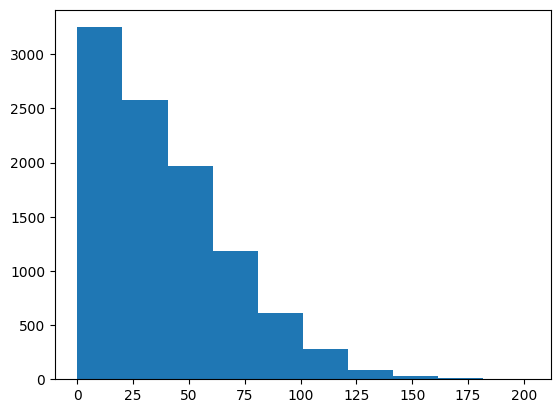

In [49]:
plt.hist(Ef_mag)

In [53]:
data["Ef"][0]

array([0.0, 0.0, 50.0], dtype=object)

In [43]:
def kabsch_align(P, Q):
    # P, Q: (n_atoms, 3) centered
    C = P.T @ Q
    V, S, Wt = np.linalg.svd(C)
    d = np.sign(np.linalg.det(V @ Wt))
    D = np.diag([1.0, 1.0, d])
    U = V @ D @ Wt
    return P @ U

def preprocess_positions(R, align=True):
    R = np.asarray(R, dtype=float)  # (n_structures, n_atoms, 3)

    # center each structure at its centroid
    Rc = R - R.mean(axis=1, keepdims=True)

    if align:
        ref = Rc[0]
        out = np.empty_like(Rc)
        out[0] = ref
        for i in range(1, Rc.shape[0]):
            out[i] = kabsch_align(Rc[i], ref)
        Rc = out

    X = Rc.reshape(Rc.shape[0], -1)  # (n_structures, 3*n_atoms)
    return X, Rc

def pca_svd(X, ncomp=10):
    X = np.asarray(X, dtype=float)
    mean = X.mean(axis=0)
    Xc = X - mean

    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)

    n = X.shape[0]
    evals = (S**2) / max(n - 1, 1)
    evr = evals / evals.sum()

    scores = U[:, :ncomp] * S[:ncomp]
    components = Vt[:ncomp]
    return scores, components, evals[:ncomp], evr[:ncomp], mean

X, Rc = preprocess_positions(R, align=True)
scores, components, evals, evr, mean = pca_svd(X, ncomp=10)

print("Explained variance ratio (first 10):")
for i, r in enumerate(evr, start=1):
    print(f"PC{i}: {r:.6f}")

Explained variance ratio (first 10):
PC1: 0.999623
PC2: 0.000009
PC3: 0.000006
PC4: 0.000005
PC5: 0.000005
PC6: 0.000005
PC7: 0.000005
PC8: 0.000005
PC9: 0.000005
PC10: 0.000005


In [39]:
scores, components, evals, evr, mean = pca_svd(X[idx_pos], ncomp=10)

print("Explained variance ratio (first 10):")
for i, r in enumerate(evr, start=1):
    print(f"PC{i}: {r:.6f}")

Explained variance ratio (first 10):
PC1: 0.032697
PC2: 0.017436
PC3: 0.015019
PC4: 0.014993
PC5: 0.014807
PC6: 0.014697
PC7: 0.014478
PC8: 0.014394
PC9: 0.014297
PC10: 0.014240


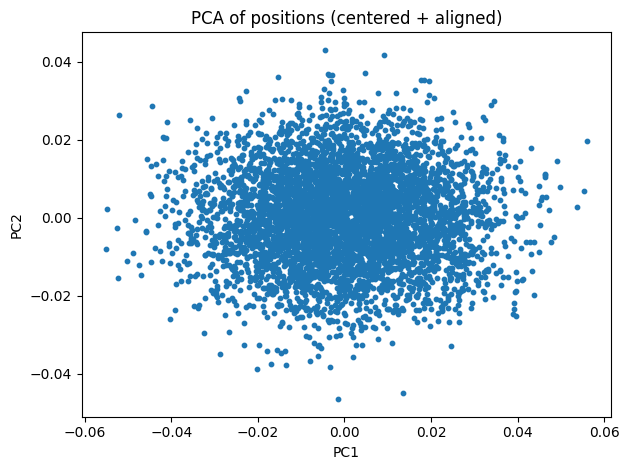

In [41]:
plt.figure()
plt.scatter(scores[:, 0], scores[:, 1], s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of positions (centered + aligned)")
plt.tight_layout()

In [8]:
pc1 = scores[:, 0]
idx_pos = np.where(pc1 >= 0)[0]
idx_neg = np.where(pc1 < 0)[0]

9.877391122648288e-05
9.947661888467144e-05


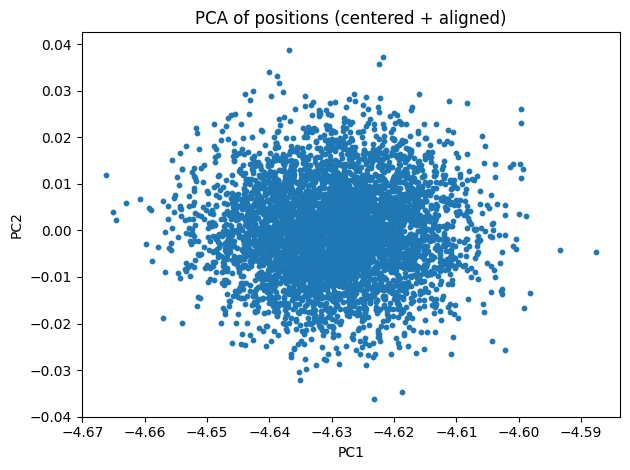

In [46]:
plt.figure()
plt.scatter(scores[:, 0][mask], scores[:, 1][mask], s=10,)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of positions (centered + aligned)")
plt.tight_layout()


for _ in [scores[:, 0][mask], scores[:, 1][mask]]:
    var = np.std(_)**2
    print(var)

# plt.axhline(scores[1, 1])
# plt.axvline(scores[1, 0])
plt.show()

In [68]:
D[1]

array([-0.1735,  3.7187, -0.5442])

In [34]:
import ase
from ase import Atoms
from ase.visualize import view
Z = data["Z"]
a_ = Atoms(Z[0], R[0])
view(a_, viewer="x3d")

In [36]:
b_ = Atoms(Z[1], R[1])
view(b_, viewer="x3d")

In [33]:
def signed_angle_deg(a, b, n, eps=1e-12):
    a = np.asarray(a, float)
    b = np.asarray(b, float)
    n = np.asarray(n, float)
    n = n / max(np.linalg.norm(n), eps)

    na = np.linalg.norm(a, axis=1)
    nb = np.linalg.norm(b, axis=1)
    ok = (na > eps) & (nb > eps)

    au = np.zeros_like(a); bu = np.zeros_like(b)
    au[ok] = a[ok] / na[ok, None]
    bu[ok] = b[ok] / nb[ok, None]

    y = np.einsum("ij,j->i", np.cross(au, bu), n)   # n·(a×b)
    x = np.einsum("ij,ij->i", au, bu)               # a·b
    ang = np.degrees(np.arctan2(y, x))
    ang[~ok] = np.nan
    return ang

# Example: use lab z-axis as the sign convention
n_ref = np.array([0.0, 0.0, 1.0])

D  = np.asarray(data["D"], dtype=float)    # (N,3)
Ef = np.asarray(data["Ef"], dtype=float)   # (N,3)
E  = np.asarray(data["E"], dtype=float)    # (N,)

D_mag  = np.linalg.norm(D, axis=1)
Ef_mag = np.linalg.norm(Ef, axis=1)

print(D.shape, D.dtype, D_mag.shape)

n_ref = np.array([0.0, 0.0, 1.0])
theta_signed = signed_angle_deg(D, Ef, n_ref)

(10000, 3) float64 (10000,)


(array([ 880.,  828.,  719.,   25., 2176.,  751.,   30.,  770.,  865.,
        2805.]),
 array([-1.79996180e+02, -1.43996562e+02, -1.07996944e+02, -7.19973259e+01,
        -3.59977079e+01,  1.91007154e-03,  3.60015281e+01,  7.20011460e+01,
         1.08000764e+02,  1.44000382e+02,  1.80000000e+02]),
 <BarContainer object of 10 artists>)

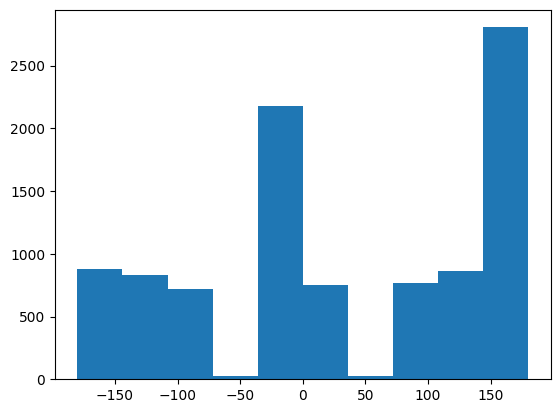

In [11]:
plt.hist(theta_signed)

(array([3.000e+00, 2.700e+01, 1.460e+02, 4.250e+02, 1.132e+03, 7.268e+03,
        6.520e+02, 2.750e+02, 6.500e+01, 7.000e+00]),
 array([-8.724  , -7.51878, -6.31356, -5.10834, -3.90312, -2.6979 ,
        -1.49268, -0.28746,  0.91776,  2.12298,  3.3282 ]),
 <BarContainer object of 10 artists>)

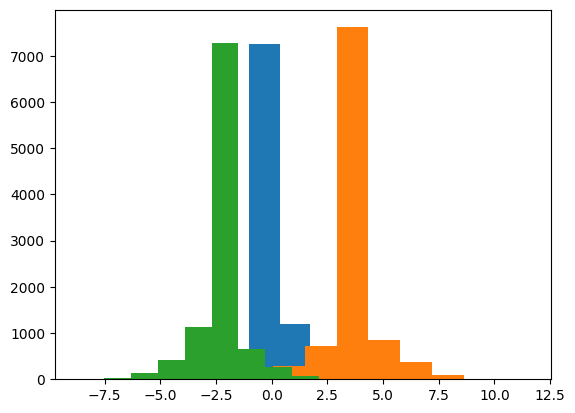

In [78]:
plt.hist(D[:,0])
plt.hist(D[:,1])
plt.hist(D[:,2])

(array([   7.,   25.,  118.,  263., 1946., 2188.,  298.,  110.,   35.,
          10.]),
 array([-6.5007 , -5.22958, -3.95846, -2.68734, -1.41622, -0.1451 ,
         1.12602,  2.39714,  3.66826,  4.93938,  6.2105 ]),
 <BarContainer object of 10 artists>)

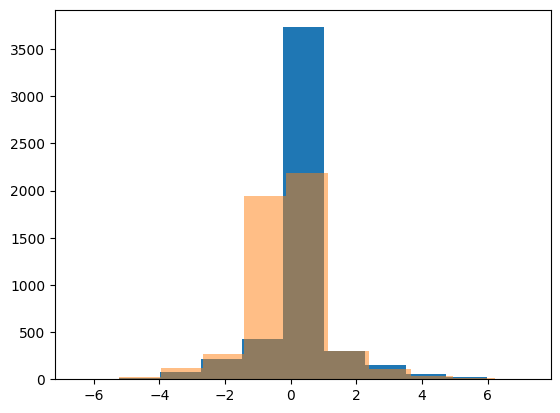

In [142]:
mask = pc1 >= 0
plt.hist(D[:,0][mask])
# plt.hist(D[:,1])
# plt.hist(D[:,2])
mask = pc1 <= 0
plt.hist(D[:,0][mask], alpha=0.5)

(array([   7.,   25.,  118.,  263., 1946., 2188.,  298.,  110.,   35.,
          10.]),
 array([-6.5007 , -5.22958, -3.95846, -2.68734, -1.41622, -0.1451 ,
         1.12602,  2.39714,  3.66826,  4.93938,  6.2105 ]),
 <BarContainer object of 10 artists>)

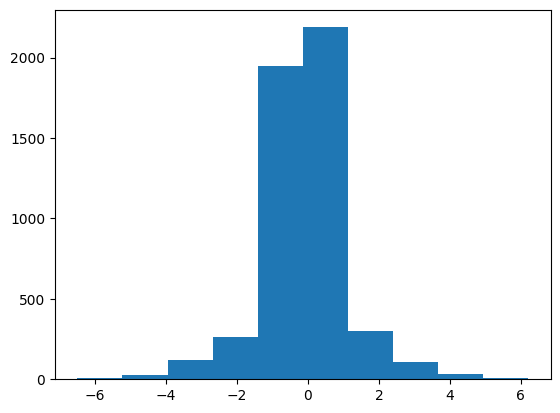

In [140]:

# plt.hist(D[:,1])
# plt.hist(D[:,2])

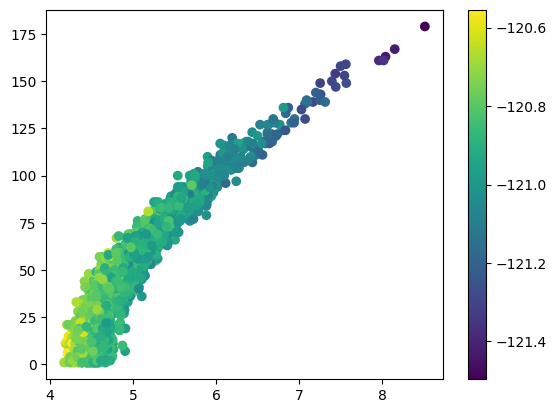

In [84]:
mask = pc1 >= 0
mask = Ef[:,0] != 0
s = plt.scatter(D_mag[mask], Ef_mag[mask], c=E[mask], cmap="viridis")
plt.colorbar(s)
# plt.ylim(0, 180)

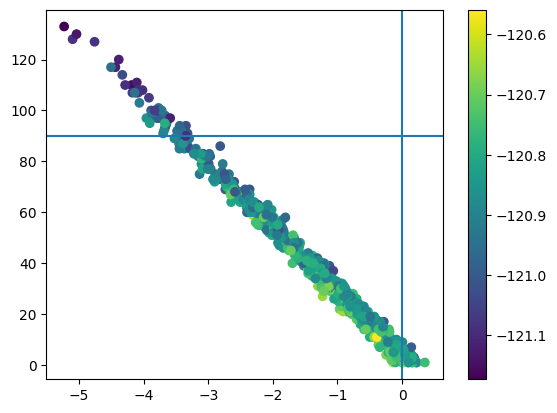

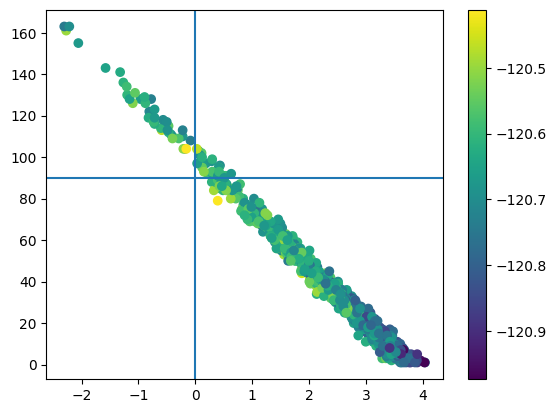

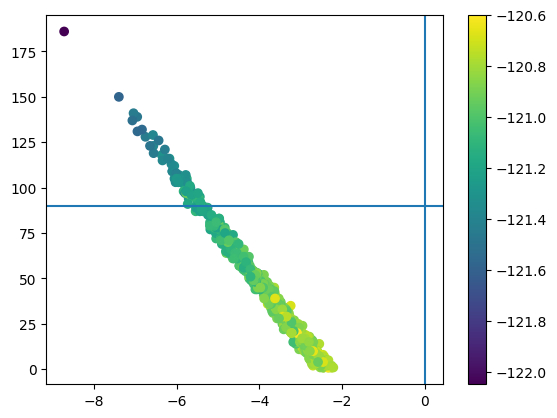

In [103]:
# mask = 
for i in range(3):
    mask = (Ef[:,i] > 0) * (pc1 >= 0)
    s = plt.scatter(D[mask][:,i], Ef_mag[mask], c=E[mask], cmap="viridis")
    plt.colorbar(s)
    plt.axvline(0)
    plt.axhline(90)
    # plt.ylim(0, 180)
    plt.show()

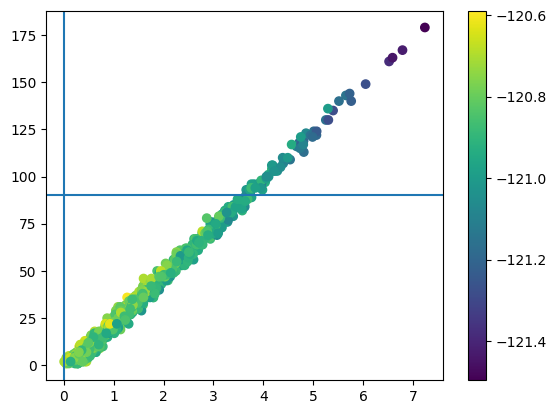

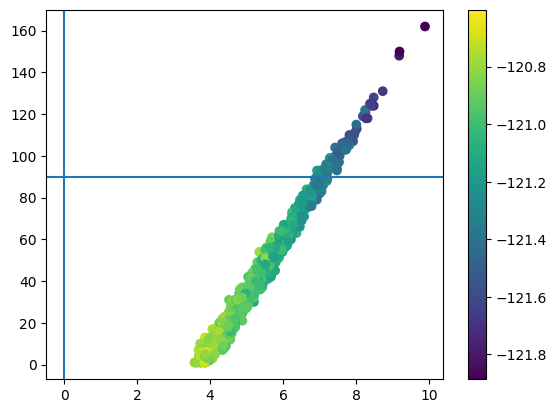

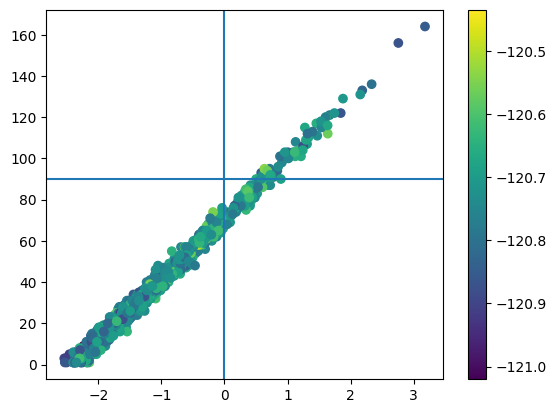

In [104]:
# mask = 
for i in range(3):
    mask = (Ef[:,i] < 0) * (pc1 >= 0)
    s = plt.scatter(D[mask][:,i], Ef_mag[mask], c=E[mask], cmap="viridis")
    plt.colorbar(s)
    plt.axvline(0)
    plt.axhline(90)
    # plt.ylim(0, 180)
    plt.show()

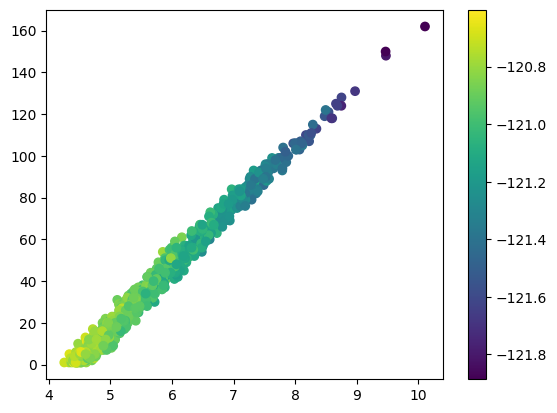

In [98]:
# mask = 
mask = (Ef[:,1] < 0) * (pc1 >= 0)
s = plt.scatter(D_mag[mask], Ef_mag[mask], c=E[mask], cmap="viridis")
plt.colorbar(s)
# plt.ylim(0, 180)

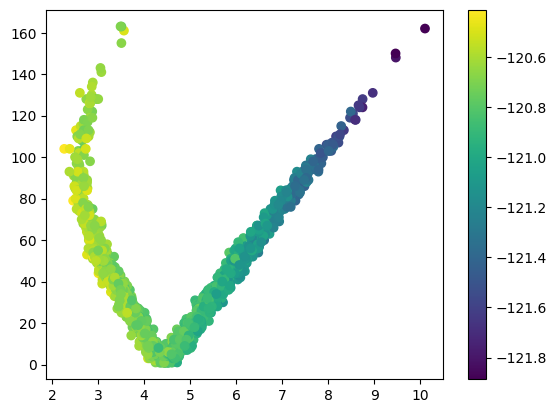

In [99]:
# mask = 
mask = (Ef[:,1] != 0) * (pc1 >= 0)
s = plt.scatter(D_mag[mask], Ef_mag[mask], c=E[mask], cmap="viridis")
plt.colorbar(s)
# plt.ylim(0, 180)

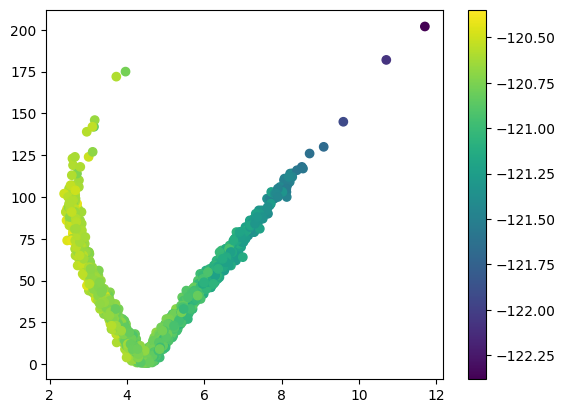

In [91]:
# mask = 
mask = (Ef[:,1] != 0) * (pc1 <= 0)
s = plt.scatter(D_mag[mask], Ef_mag[mask], c=E[mask], cmap="viridis")
plt.colorbar(s)
# plt.ylim(0, 180)

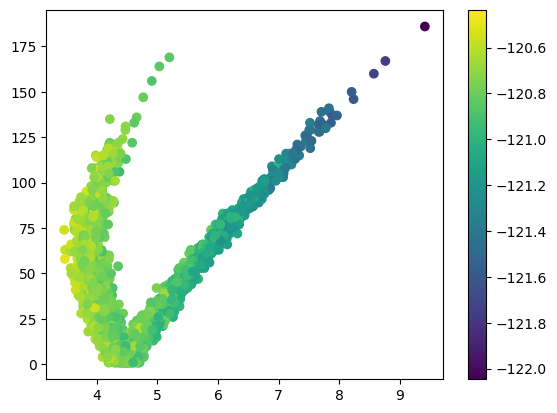

In [86]:
mask = pc1 >= 0
mask = Ef[:,2] != 0
s = plt.scatter(D_mag[mask], Ef_mag[mask], c=E[mask], cmap="viridis")
plt.colorbar(s)
# plt.ylim(0, 180)

(0.0, 180.0)

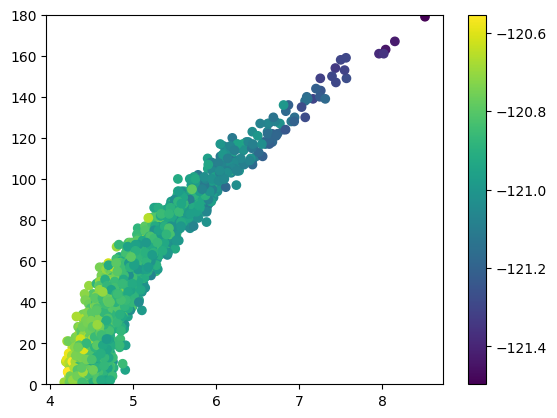

In [81]:
mask = pc1 >= 0
mask = Ef[:,0] != 0
s = plt.scatter(D_mag[mask], Ef_mag[mask], c=E[mask], cmap="viridis")
plt.colorbar(s)
plt.ylim(0, 180)

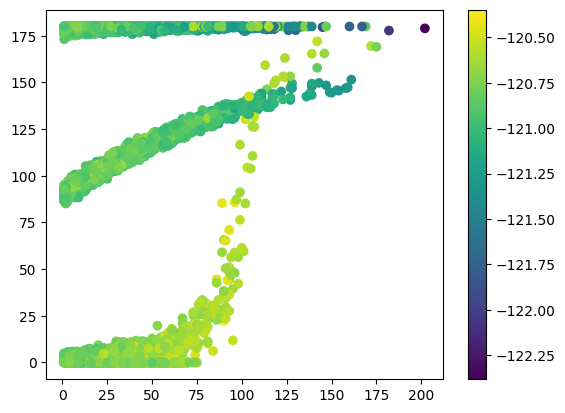

In [27]:
mask = ~(pc1 >= 0)
s = plt.scatter(Ef_mag[mask], abs(theta_signed[mask]), c=E[mask], cmap="viridis")
plt.colorbar(s)

array([False,  True, False, ...,  True, False,  True], shape=(10000,))

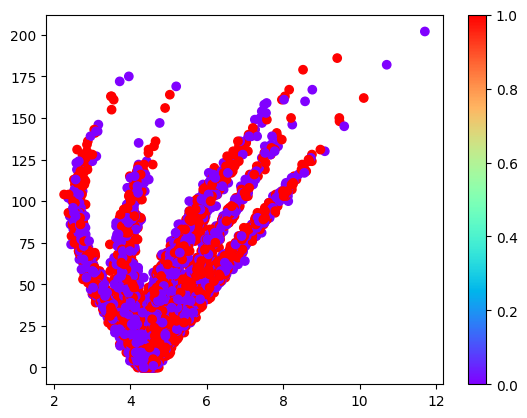

In [13]:
s = plt.scatter(D_mag, Ef_mag, c=, cmap="rainbow")
plt.colorbar(s)

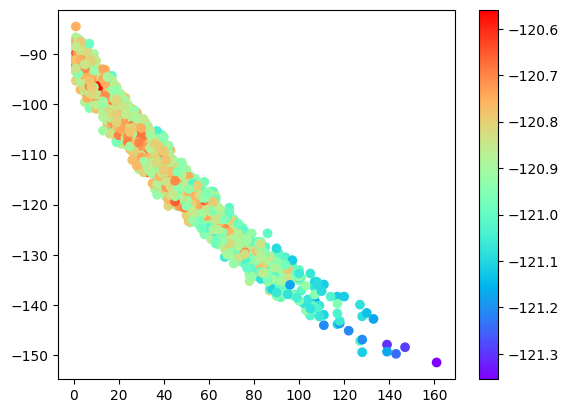

In [109]:
mask = (Ef[:,0] > 0)

s = plt.scatter(Ef_mag[mask], theta_signed[mask], c=E[mask], cmap="rainbow")
plt.colorbar(s)

/scratch/boitti0000/slurm-job.5056015/ipykernel_1551062/1412666458.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  s = plt.scatter(Ef_mag[mask], E[mask], cmap="rainbow")


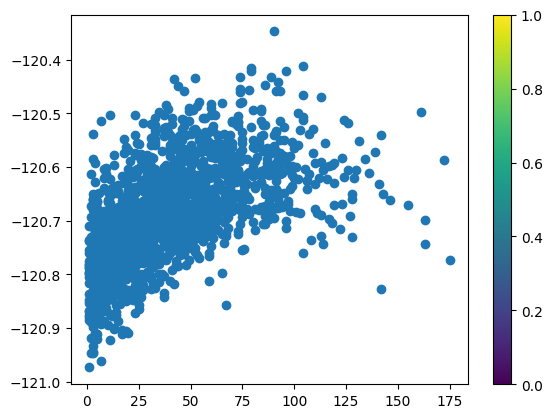

In [119]:
mask = (Ef[:,1] > 0) # & (pc1 >= 0)

s = plt.scatter(Ef_mag[mask], E[mask], cmap="rainbow")
plt.colorbar(s)

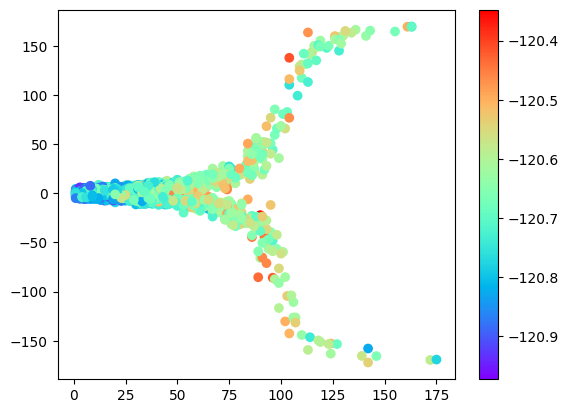

In [132]:
mask = (Ef[:,1] > 0)

s = plt.scatter(Ef_mag[mask], theta_signed[mask], c=E[mask], cmap="rainbow")
plt.colorbar(s)

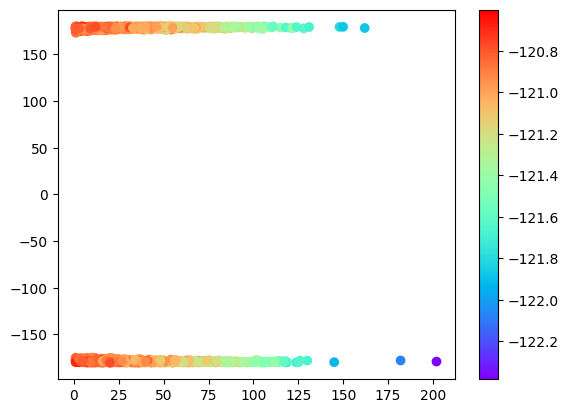

In [111]:
mask = (Ef[:,1] < 0)

s = plt.scatter(Ef_mag[mask], theta_signed[mask], c=E[mask], cmap="rainbow")
plt.colorbar(s)

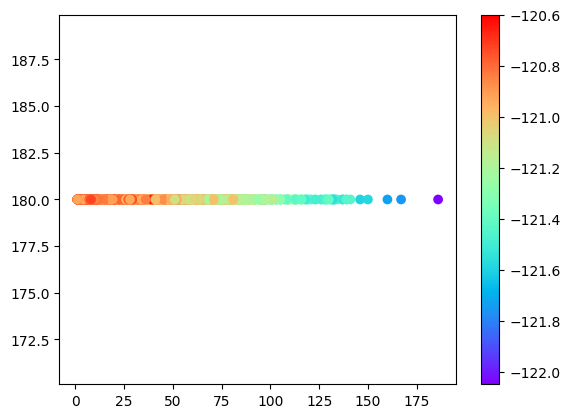

In [112]:
mask = (Ef[:,2] > 0)

s = plt.scatter(Ef_mag[mask], theta_signed[mask], c=E[mask], cmap="rainbow")
plt.colorbar(s)

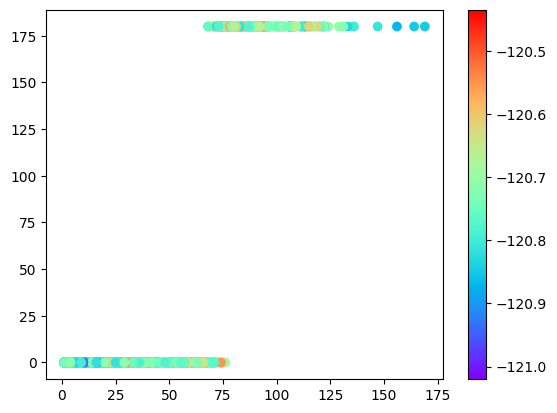

In [113]:
mask = (Ef[:,2] < 0)

s = plt.scatter(Ef_mag[mask], theta_signed[mask], c=E[mask], cmap="rainbow")
plt.colorbar(s)